In [1]:
# import dependencies
import numpy as np
from numpy.linalg import inv
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from __future__ import division
from scipy import stats

In [2]:
# make the features (x) and their classification (y)
x, y = make_blobs(n_samples=30, centers=3, n_features=2)

# create a OneHotEncoder model for the y-data
enc = OneHotEncoder()
enc.fit(y.reshape(-1, 1))
# one-hot array for classifiers
y_hot = enc.transform(y.reshape(-1, 1)).toarray() 

print(y)
print(y_hot)

[1 0 0 1 0 1 1 2 0 2 2 2 1 0 0 2 2 0 1 2 2 2 2 0 1 1 0 1 0 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [3]:
x_tilde = np.hstack((np.ones((len(x), 1)), x))

# X.T * X
XX = np.matmul(x_tilde.T, x_tilde)
# one-hot K-dimensional vectors for classifications
T = y_hot
# X.T * T
XT = np.matmul(x_tilde.T, T)

print("Shape of T:", np.shape(T))

# Beta should be size K x (D + 1)
# where K is the number of categories
# and D is the number of features

# B = (X.T * X)^-1 * X.T * T
Beta = np.matmul(inv(XX), XT)
print(Beta)

Shape of T: (30, 3)
[[-0.72771369  1.12776868  0.59994501]
 [ 0.17744833 -0.15443154 -0.02301679]
 [ 0.05037433  0.00478929 -0.05516362]]


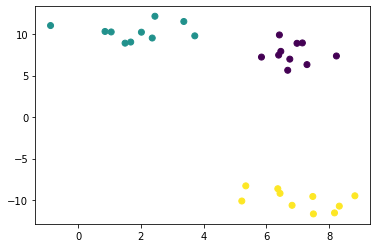

In [4]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

[[-1.47102146  1.20761238  1.26340908]
 [-1.45363362  1.19247991  1.26115371]
 [-1.43624578  1.17734745  1.25889833]
 ...
 [ 1.41481863 -0.14622201 -0.26859662]
 [ 1.43220647 -0.16135447 -0.270852  ]
 [ 1.4495943  -0.17648694 -0.27310737]]


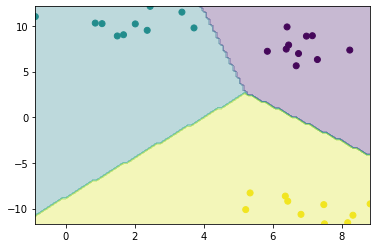

In [5]:
# X has 2 features
# select min/max of feature 1
x1min = np.min(x[:, 0])
x1max = np.max(x[:, 0])
# select min/max of feature 2
x2min = np.min(x[:, 1])
x2max = np.max(x[:, 1])

# create a set of test points for feature 1 and feature 2
# that lie between the minimum and maximum of each
xx1, xx2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))

# Create array of prediction features
xPredict = np.vstack((xx1.flatten(), xx2.flatten())).T
# create x_tilde for predictions
xTildePredict = np.hstack((np.ones((len(xPredict), 1)), xPredict))

# compute predicted classifications (one-hot) as T = BX
prediction = np.matmul(xTildePredict, Beta)
print(prediction)

# transfer from one-hot to the number
predictedTargets = np.zeros((len(prediction), 1))
for i in range(len(prediction)):
    # grab index of largets (closest to 1)
    predictedTargets[i] = np.argmax(prediction[i])
    

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.contourf(xx1, xx2, np.reshape(predictedTargets, np.shape(xx1)), alpha=0.3)
plt.show()

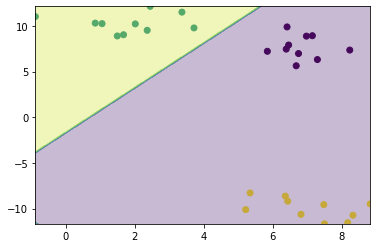

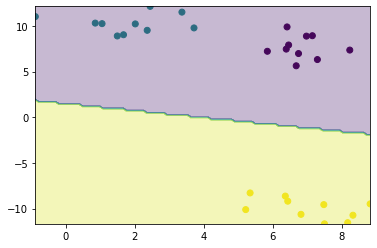

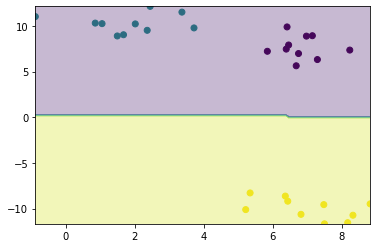

In [6]:
# One vs one approach

num_classes = max(y) + 1

# how many 1 vs 1 pairings possible
num_classifiers = int(num_classes * (num_classes - 1) / 2)

# Create matrix to store all comparisons
# will be size len(features) x num_classifiers
PredictionMatrix = np.zeros((len(xx1.flatten()), num_classifiers))

# keep track of current index of PredictionMatrix
counter = 0

# Loop through every possible combination of categories
for i in range(num_classes):
    for j in range(i + 1, num_classes):
        # get all indeces where y is classified as i
        indeces_i = np.squeeze(np.where(y == i))
        # get all indeces where y is classified as j
        indeces_j = np.squeeze(np.where(y == j))
        
        # grab all features corresponding to i and to j
        points_i = x_tilde[indeces_i, :]
        points_j = x_tilde[indeces_j, :]
        # create classes for i (y = 1) and j (y = -1)
        targets_i = np.ones((len(indeces_i), 1))
        targets_j = -np.ones((len(indeces_j), 1))
        
        # create set of features
        x_tilde_ij = np.vstack((points_i, points_j))
        # create set of targets
        targets_ij = np.vstack((targets_i, targets_j))
        
        # learning the plane
        XX = np.matmul(x_tilde_ij.T, x_tilde_ij)
        XT = np.matmul(x_tilde_ij.T, targets_ij)
        
        # B = (X^T * X)^-1 * X^T * T
        Beta_ij = np.matmul(inv(XX), XT)
        
        # recall to xTildePredict from last cell
        # calculate predictions
        prediction_ij = np.matmul(xTildePredict, Beta_ij)
        
        # gather all indeces where prediction > 0
        predict_indeces_i = np.squeeze(np.where(prediction_ij > 0))
        # gather all indeces where prediction <= 0
        predict_indeces_j = np.squeeze(np.where(prediction_ij <= 0))
        
        # create final set of classifications
        target_final_ij = np.zeros((len(prediction_ij), 1))
        target_final_ij[predict_indeces_i] = i
        target_final_ij[predict_indeces_j] = j
        
        # place predictions on the final PredictionMatrix
        PredictionMatrix[:, counter] = np.squeeze(target_final_ij)
        counter += 1
        
        # plot i vs j
        plt.scatter(x[:,0], x[:,1], c = y)
        plt.contourf(xx1, xx2, np.reshape(target_final_ij,np.shape(xx1)), alpha = .3)
        plt.show()
        

        

In [7]:
# compute final predictions
final_predictions = np.zeros((len(PredictionMatrix), 1))

for i in range(len(final_predictions)):
    # grab most voted for
    final_predictions[i] = stats.mode(PredictionMatrix[i])[0][0]
    
print(final_predictions)

[[2.]
 [2.]
 [2.]
 ...
 [0.]
 [0.]
 [0.]]
